In [65]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader

In [66]:
# Используем датасет https://www.kaggle.com/datasets/camnugent/california-housing-prices/
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [67]:
# Проверяем долю данных с недостающими значениями
print('%s%% строк с NaN' % round(100 * len(df[df.isna().any(axis=1)]) / len(df)))

# Отбрасываем такие строки
df = df.dropna()

1% строк с NaN


In [68]:
# Приводим к числовому виду столбец ocean_proximity (на поверку в среднем - ближе к океану = дороже)

df['ocean_proximity'] = df['ocean_proximity'].replace({
    'INLAND': 0.1,
    '<1H OCEAN': 0.3,
    'NEAR OCEAN': 0.5,
    'NEAR BAY': 0.7,
    'ISLAND': 0.9,
})

In [69]:
# Уносим стоимость недвижимости в отдельный датафрейм с лейблами
labels_column = 'median_house_value'
features = df.drop([labels_column], axis=1)
labels = df[[labels_column]]

features.shape, labels.shape

((20433, 9), (20433, 1))

In [70]:
# Нормализуем данные и цены
def normalize(df):
    return (df - df.min()) / (df.max() - df.min())#df/df.mean()

features = normalize(features)
labels = normalize(labels)

In [71]:
features.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,0.211155,0.567481,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668,0.75
1,0.212151,0.565356,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027,0.75
2,0.210159,0.564293,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028,0.75
3,0.209163,0.564293,1.000000,0.032352,0.036313,0.015555,0.035849,0.354699,0.75
4,0.209163,0.564293,1.000000,0.041330,0.043296,0.015752,0.042427,0.230776,0.75


In [72]:
labels.head()

,median_house_value
0,0.902266
1,0.708247
2,0.695051
3,0.672783
4,0.674638


In [73]:
features = torch.tensor(features.values, dtype=torch.float)
labels = torch.tensor(labels.values, dtype=torch.float)

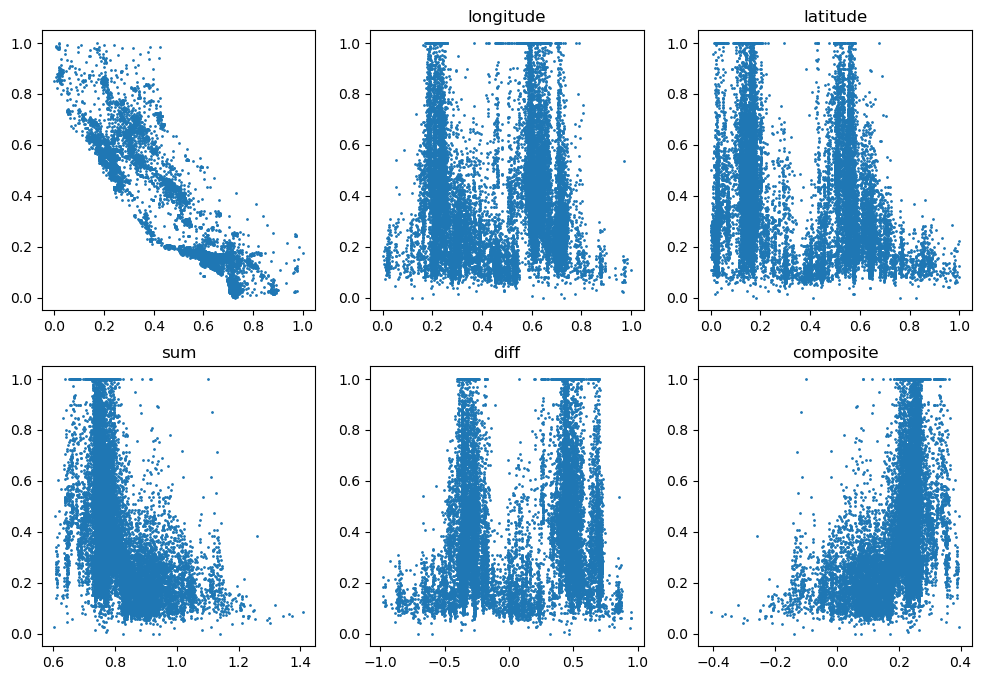

In [74]:
# Смотрим как координаты недвижимости коррелируют друг с другом и с ценой,
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.scatter(features[:, 0], features[:, 1], 1)
plt.subplot(232).title.set_text(df.columns[0])
plt.scatter(features[:, 0], labels, 1)
plt.subplot(233).title.set_text(df.columns[1])
plt.scatter(features[:, 1], labels, 1)
plt.subplot(234).title.set_text('sum')
plt.scatter(features[:, 0] + features[:, 1],labels, 1)
plt.subplot(235).title.set_text('diff')
plt.scatter(features[:, 0] - features[:, 1], labels, 1)
plt.subplot(236).title.set_text('composite')
plt.scatter(1 - features[:, 0] - features[:, 1], labels, 1)
plt.show()

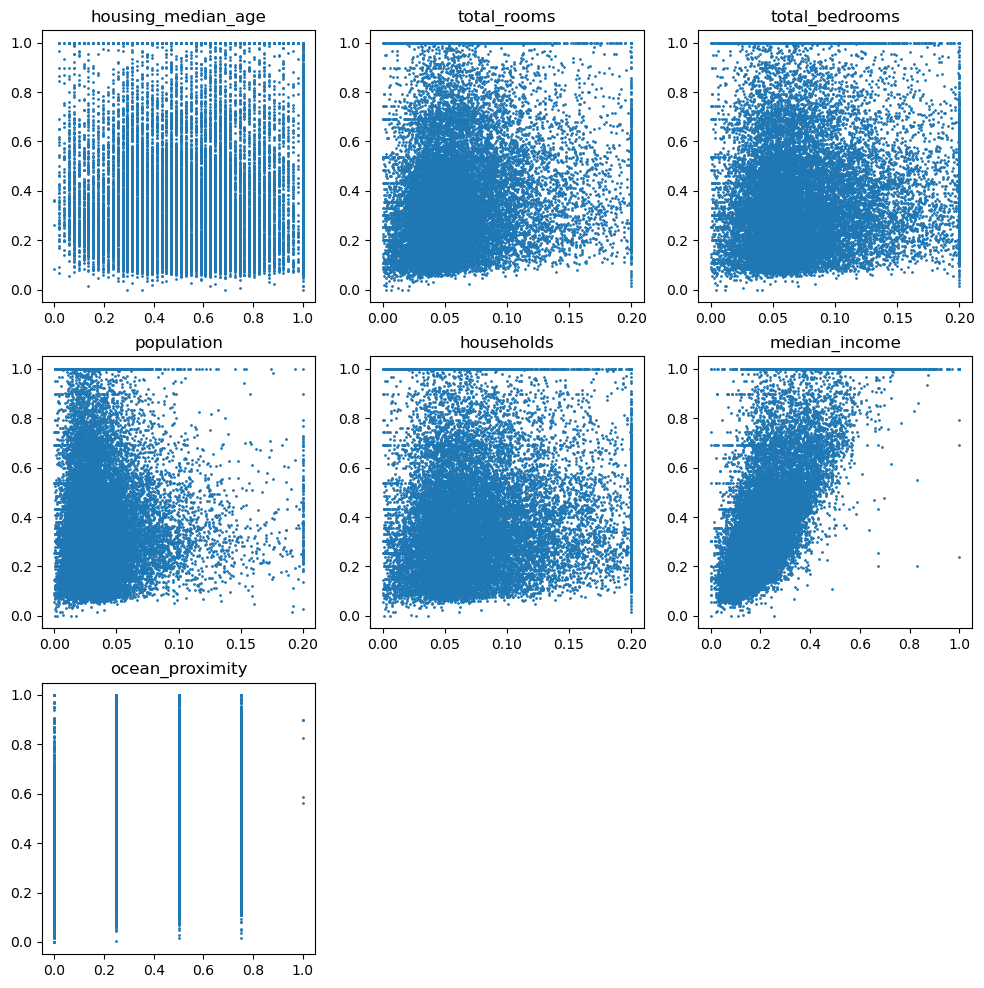

In [75]:
# Смотрим на корреляцию остальных столбцов с ценой
plt.figure(figsize=(12, 12))

plt.subplot(331).title.set_text(df.columns[2])
plt.scatter(features[:, 2], labels, 1)
plt.subplot(332).title.set_text(df.columns[3])
plt.scatter(torch.clamp(features[:, 3], 0, 0.2), labels, 1)
plt.subplot(333).title.set_text(df.columns[4])
plt.scatter(torch.clamp(features[:, 4], 0, 0.2), labels, 1)
plt.subplot(334).title.set_text(df.columns[5])
plt.scatter(torch.clamp(features[:, 5], 0, 0.2), labels, 1)
plt.subplot(335).title.set_text(df.columns[6])
plt.scatter(torch.clamp(features[:, 6], 0, 0.2), labels, 1)
plt.subplot(336).title.set_text(df.columns[7])
plt.scatter(features[:, 7], labels, 1)
plt.subplot(337).title.set_text(df.columns[9])
plt.scatter(features[:, 8], labels, 1)

In [76]:
# Убираем housing_median_age и приводим координаты к более-менее линейному виду
features = df.drop([labels_column], axis=1)
labels = df[[labels_column]]

features['coordinates'] = (1 - features['longitude'] - features['latitude'])
features = features.drop(['longitude', 'latitude', 'housing_median_age'], axis=1)

features = normalize(features)
labels = normalize(labels)

In [77]:
# Разделяем данные на тренировочные и проверочные как 70-30%
X_train, X_test, y_train, y_test = train_test_split(features.values, labels.values, train_size = 0.7, shuffle = True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [85]:
# Собираем все в объект TensorDataset, создаем DataLoader для итерации по данным партиями по 16 примеров
batch_size = 16
dataset = TensorDataset(X_train, y_train)
data_iter = DataLoader(dataset, batch_size, shuffle=True)

In [90]:
# Создаем модель одиночного нейрона и иницализируем веса и смещение
model = torch.nn.Sequential(torch.nn.Linear(X_train.shape[1], 1))
model[0].weight.data = torch.tensor([[1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 0.25]], requires_grad = True)
#model[0].weight.data = torch.full((1,X_train.shape[1]), 1.0).requires_grad_(True);
model[0].bias.data = torch.tensor([0.0], requires_grad = True)

In [91]:
# Определяем функцию потерь
loss = torch.nn.MSELoss(reduction='mean')

In [92]:
# Определяем SGD оптимизатор
trainer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [93]:
# 
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        trainer.zero_grad()
        l = loss(model(X.float()).reshape(-1), y.float())
        l.backward()
        trainer.step()
    l = loss(model(X_test.float()).reshape(-1), y_test.float())
    if epoch % 10 == 0:
        print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 10, loss: 0.126194
epoch 20, loss: 0.122495
epoch 30, loss: 0.119404
epoch 40, loss: 0.116513
epoch 50, loss: 0.113795
epoch 60, loss: 0.111240
epoch 70, loss: 0.108826
epoch 80, loss: 0.106549
epoch 90, loss: 0.104394
epoch 100, loss: 0.102354


In [94]:
# Смотрим примеры значений
for i in range(1,10):
    print('predicted %f, actual: %f' % (model(X_test[i].float()).item(), y_test[i].item()))

predicted 0.456200, actual: 0.711133
predicted 0.254007, actual: 0.290104
predicted 0.424992, actual: 0.527629
predicted 0.314351, actual: 0.554845
predicted 0.153438, actual: 0.120414
predicted 0.271989, actual: 0.480825
predicted 0.179528, actual: 0.163919
predicted 0.779473, actual: 1.000000
predicted 0.447632, actual: 0.323918


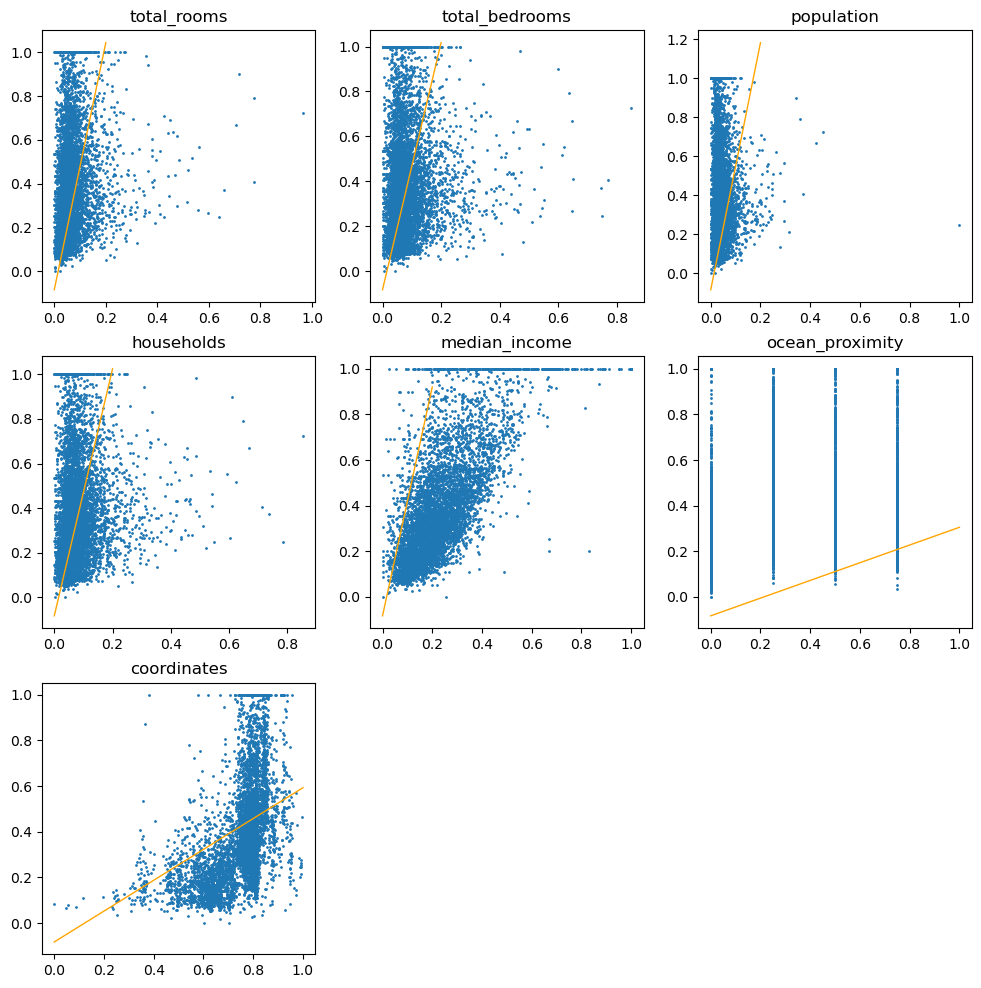

In [107]:
# Визуализируем веса
weights = model[0].weight.data[0] * X_train.shape[1]
bias = model[0].bias.data.item()


plt.figure(figsize=(12, 12))

plt.subplot(331).title.set_text(df.columns[3])
plt.scatter(X_test[:, 0], y_test, 1)
plt.plot([0.0, 0.2], [bias + x * weights[0].item() for x in [0.0, 0.2]], color='orange', linewidth=1)

plt.subplot(332).title.set_text(df.columns[4])
plt.scatter(X_test[:, 1], y_test, 1)
plt.plot([0.0, 0.2], [bias + x * weights[1].item() for x in [0.0, 0.2]], color='orange', linewidth=1)


plt.subplot(333).title.set_text(df.columns[5])
plt.scatter(X_test[:, 2], y_test, 1)
plt.plot([0.0, 0.2], [bias + x * weights[2].item() for x in [0.0, 0.2]], color='orange', linewidth=1)

plt.subplot(334).title.set_text(df.columns[6])
plt.scatter(X_test[:, 3], y_test, 1)
plt.plot([0.0, 0.2], [bias + x * weights[3].item() for x in [0.0, 0.2]], color='orange', linewidth=1)

plt.subplot(335).title.set_text(df.columns[7])
plt.scatter(X_test[:, 4], y_test, 1)
plt.plot([0.0, 0.2], [bias + x * weights[4].item() for x in [0.0, 0.2]], color='orange', linewidth=1)

plt.subplot(336).title.set_text(df.columns[9])
plt.scatter(X_test[:, 5], y_test, 1)
plt.plot([0.0, 1.0], [bias + x * weights[5].item() for x in [0.0, 1.0]], color='orange', linewidth=1)

plt.subplot(337).title.set_text('coordinates')
plt.scatter(X_test[:, 6], y_test, 1)
plt.plot([0.0, 1.0], [bias + x * weights[6].item() for x in [0.0, 1.0]], color='orange', linewidth=1)